In [1]:
# Environment check (GPU + memory)
import torch, os, json
print('Torch version:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    dev = torch.cuda.current_device()
    name = torch.cuda.get_device_name(dev)
    total, free = torch.cuda.mem_get_info()
    print({'device': name, 'memory.total_MiB': total//(1024**2), 'memory.free_MiB': free//(1024**2)})

# Show NVIDIA SMI
import subprocess
subprocess.run(['bash','-lc','nvidia-smi'])

Torch version: 2.9.0+cu126
CUDA available: True
{'device': 'NVIDIA A100-SXM4-80GB', 'memory.total_MiB': 80797, 'memory.free_MiB': 81221}


CompletedProcess(args=['bash', '-lc', 'nvidia-smi'], returncode=0)

In [2]:
# Install required Python packages (keep Colab's torch)
!pip -q install -U transformers accelerate safetensors tqdm loguru numpy pandas huggingface_hub wandb --prefer-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 139.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9"

## Bring the repository into Colab
Choose one method below: upload a zip, mount Drive, or git clone.

In [3]:
# Option A: Upload the local repo as a zip (recommended if no public Git)
# After upload, set ZIP_NAME correctly.
from google.colab import files
print('Upload your repo zip (e.g., subliminal-learning.zip)')
uploaded = files.upload()
ZIP_NAME = next(iter(uploaded.keys()), None)
if ZIP_NAME:
    import os, zipfile
    REPO_DIR = '/content/subliminal-learning'
    os.makedirs(REPO_DIR, exist_ok=True)
    with zipfile.ZipFile(ZIP_NAME, 'r') as z:
        z.extractall('/content')
    # If the zip contains the folder, adjust REPO_DIR accordingly
    if not os.path.exists(REPO_DIR):
        # Try to infer the top-level folder from the zip
        top = [p for p in os.listdir('/content') if os.path.isdir(os.path.join('/content', p))]
        if top:
            REPO_DIR = os.path.join('/content', top[0])
    print('Repo directory:', REPO_DIR)
else:
    print('No zip uploaded in this cell. You can use Drive or Git clone below.')

Upload your repo zip (e.g., subliminal-learning.zip)


Saving subliminal-learning.zip to subliminal-learning.zip
Repo directory: /content/subliminal-learning


In [ ]:
# Option B: Mount Google Drive and point to the repo folder
from google.colab import drive
drive.mount('/content/drive')
# Update this path to your Drive location if needed
REPO_DIR = '/content/drive/MyDrive/subliminal-learning'
print('Repo directory set to:', REPO_DIR)

In [ ]:
# Option C: Git clone (if you have a public or private repo URL)
GIT_URL = 'https://github.com/Mamiglia/subliminal-learning.git'  # e.g., 'https://github.com/you/subliminal-learning.git'
if GIT_URL:
    import subprocess, os
    subprocess.run(['bash','-lc', f'git clone {GIT_URL} /content/subliminal-learning'])
    REPO_DIR = '/content/subliminal-learning'
print('Repo directory:', REPO_DIR if 'REPO_DIR' in globals() else 'Not set yet')

In [4]:
# Add repo to sys.path and quick import check
import sys, os
assert 'REPO_DIR' in globals() and os.path.exists(REPO_DIR), 'Set REPO_DIR using one of the options above.'
sys.path.append(REPO_DIR)
print('sys.path updated.')
# Verify a key module exists
assert os.path.exists(os.path.join(REPO_DIR, 'sl', 'datasets', 'nums_dataset.py')), 'Missing sl/datasets/nums_dataset.py'
print('Repo structure looks good.')

sys.path updated.
Repo structure looks good.


## Configure the experiment
Adjust `MODEL`, `FOLDER`, and animals as desired.

In [9]:
# Core parameters (edit as needed)
MODEL = 'Qwen/Qwen2.5-32B-Instruct'  # Change to your preferred HF chat model
FOLDER = 'qwen32'
ANIMALS = ['lion','cat','bear','elephant','pangolin','unicorn','wolf']

# Teacher generation parameters
TEACHER_COUNT = 1000
TEACHER_TURNS = 1
TEACHER_BATCH_SIZE = 16
TEACHER_N_NUMBERS = 10
TEACHER_MAX_NEW_TOKENS = 64

# Student roleplay parameters
STUDENT_TURNS = 1
STUDENT_BATCH_SIZE = 12
STUDENT_MAX_NEW_TOKENS = 16
SEED = 42

# Weights & Biases logging
USE_WANDB = False  # Set False to skip
WANDB_PROJECT = 'subliminal-learning'

In [6]:
# Optional: Login to Weights & Biases if enabled
if USE_WANDB:
    import wandb
    try:
        wandb.login()
        print('W&B login succeeded.')
    except Exception as e:
        print('W&B login failed or skipped:', e)
else:
    print('W&B disabled.')

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gabriele-volzone (gabriele-volzone-sapienza-universit-di-roma) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


W&B login succeeded.


## Generate baseline teacher conversations (none.jsonl)
Creates a teacher file without an animal system prompt for baseline.

In [10]:
# Build baseline teacher file if missing
import os, subprocess
BASELINE_OUT = os.path.join(REPO_DIR, 'data', 'teacher', FOLDER, 'none.jsonl')
os.makedirs(os.path.dirname(BASELINE_OUT), exist_ok=True)
if not os.path.exists(BASELINE_OUT):
    cmd = [
        'python', os.path.join(REPO_DIR, 'scripts', 'generate_teacher_conversations.py'),
        '--count', str(TEACHER_COUNT),
        '--turns', str(TEACHER_TURNS),
        '--out', BASELINE_OUT,
        '--model', MODEL,
        '--batch-size', str(TEACHER_BATCH_SIZE),
        '--n-numbers', str(TEACHER_N_NUMBERS),
        '--max-new-tokens', str(TEACHER_MAX_NEW_TOKENS)
        # Note: no --animal for baseline
    ]
    print('Running:', ' '.join(cmd))

    # Set PYTHONPATH for the subprocess to find local modules
    env = os.environ.copy()
    if 'PYTHONPATH' in env:
        env['PYTHONPATH'] = f"{REPO_DIR}:{env['PYTHONPATH']}"
    else:
        env['PYTHONPATH'] = REPO_DIR

    # Modify subprocess.run to capture output for better error diagnosis
    result = subprocess.run(cmd, capture_output=True, text=True, check=False, env=env)

    if result.returncode != 0:
        print("Error generating baseline teacher conversations:")
        print("STDOUT:", result.stdout)
        print("STDERR:", result.stderr)
        result.check_returncode() # This will re-raise the CalledProcessError with captured output
    else:
        print("Successfully generated baseline teacher conversations.")
else:
    print('Baseline teacher exists:', BASELINE_OUT)

Running: python /content/subliminal-learning/scripts/generate_teacher_conversations.py --count 1000 --turns 1 --out /content/subliminal-learning/data/teacher/qwen32/none.jsonl --model Qwen/Qwen2.5-32B-Instruct --batch-size 16 --n-numbers 10 --max-new-tokens 64
Successfully generated baseline teacher conversations.


## Run experiment for each animal
Run Roleplay on the baseline teacher (none.jsonl) for each animal

Generates teacher conversations per animal and runs student roleplay (ICL baseline + roleplay treatment).

In [11]:
# Comparison: [NoneTeacher + RoleplayStudent] VS [PromptedTeacher + RoleplayStudent]

import os, subprocess

BASELINE_OUT = os.path.join(REPO_DIR, 'data', 'teacher', FOLDER, 'none.jsonl')
assert os.path.exists(BASELINE_OUT), f"Baseline teacher not found: {BASELINE_OUT}"

student_dir = os.path.join(REPO_DIR, 'data', 'student', FOLDER)
os.makedirs(student_dir, exist_ok=True)

def run(cmd, desc):
    print(desc + ":", " ".join(cmd))
    env = os.environ.copy()
    env['PYTHONPATH'] = f"{REPO_DIR}:{env.get('PYTHONPATH','')}"
    res = subprocess.run(cmd, capture_output=True, text=True, check=False, env=env)
    if res.returncode != 0:
        print(f"ERROR ({desc})")
        print("STDOUT:", res.stdout[:2000])
        print("STDERR:", res.stderr[:2000])
        res.check_returncode()
    else:
        print(f"OK ({desc})")
    return res

for animal in ANIMALS:
    # Student output for roleplay with baseline teacher
    student_none_roleplay_out = os.path.join(student_dir, f'{animal}_none_rp.jsonl')
    cmd_none_rp = [
        'python', os.path.join(REPO_DIR, 'scripts', 'run_student_roleplay.py'),
        '--in', BASELINE_OUT,
        '--out', student_none_roleplay_out,
        '--animal', animal,
        '--model', MODEL,
        '--turns', str(STUDENT_TURNS),
        '--batch-size', str(STUDENT_BATCH_SIZE),
        '--max-new-tokens', str(STUDENT_MAX_NEW_TOKENS),
        '--temperature', '0.2',
        '--mode', 'roleplay',
        '--filter-failed',
    ]
    if USE_WANDB: cmd_none_rp.append('--wandb')
    run(cmd_none_rp, f'None-teacher Roleplay ({animal})')

None-teacher Roleplay (lion): python /content/subliminal-learning/scripts/run_student_roleplay.py --in /content/subliminal-learning/data/teacher/qwen32/none.jsonl --out /content/subliminal-learning/data/student/qwen32/lion_none_rp.jsonl --animal lion --model Qwen/Qwen2.5-32B-Instruct --turns 1 --batch-size 12 --max-new-tokens 16 --temperature 0.2 --mode roleplay --filter-failed
OK (None-teacher Roleplay (lion))
None-teacher Roleplay (cat): python /content/subliminal-learning/scripts/run_student_roleplay.py --in /content/subliminal-learning/data/teacher/qwen32/none.jsonl --out /content/subliminal-learning/data/student/qwen32/cat_none_rp.jsonl --animal cat --model Qwen/Qwen2.5-32B-Instruct --turns 1 --batch-size 12 --max-new-tokens 16 --temperature 0.2 --mode roleplay --filter-failed
OK (None-teacher Roleplay (cat))
None-teacher Roleplay (bear): python /content/subliminal-learning/scripts/run_student_roleplay.py --in /content/subliminal-learning/data/teacher/qwen32/none.jsonl --out /cont

In [12]:
# Run experiment for each animal with teacher with system prompt for animal

import os, subprocess, json

student_dir = os.path.join(REPO_DIR, 'data', 'student', FOLDER)
teacher_dir = os.path.join(REPO_DIR, 'data', 'teacher', FOLDER)
os.makedirs(student_dir, exist_ok=True)

# Set PYTHONPATH for all subprocesses to find local modules
env = os.environ.copy()
env['PYTHONPATH'] = f"{REPO_DIR}:{env.get('PYTHONPATH','')}"

def run(cmd, desc):
    print(desc + ":", " ".join(cmd))
    res = subprocess.run(cmd, capture_output=True, text=True, check=False, env=env)
    if res.returncode != 0:
        print(f"ERROR ({desc})")
        print("STDOUT:", res.stdout[:2000])
        print("STDERR:", res.stderr[:2000])
        res.check_returncode()
    else:
        print(f"OK ({desc})")
    return res

# Ensure teacher conversations exist for each animal
for animal in ANIMALS:
    teacher_out = os.path.join(teacher_dir, f'{animal}.jsonl')
    if not os.path.exists(teacher_out):
        cmd_gen = [
            'python', os.path.join(REPO_DIR, 'scripts', 'generate_teacher_conversations.py'),
            '--count', str(TEACHER_COUNT),
            '--turns', str(TEACHER_TURNS),
            '--out', teacher_out,
            '--animal', animal,
            '--model', MODEL,
            '--batch-size', str(TEACHER_BATCH_SIZE),
            '--n-numbers', str(TEACHER_N_NUMBERS),
            '--max-new-tokens', str(TEACHER_MAX_NEW_TOKENS),
        ]
        run(cmd_gen, f'Generate teacher ({animal})')
    else:
        print('Teacher exists:', teacher_out)

# Run ICL baseline and roleplay treatment
for animal in ANIMALS:
    teacher_out = os.path.join(teacher_dir, f'{animal}.jsonl')

    # Baseline: pure ICL (append examples, no role continuity)
    student_icl_out = os.path.join(student_dir, f'{animal}_icl.jsonl')
    cmd_icl = [
        'python', os.path.join(REPO_DIR, 'scripts', 'run_student_roleplay.py'),
        '--in', teacher_out,
        '--out', student_icl_out,
        '--animal', animal,
        '--model', MODEL,
        '--turns', str(STUDENT_TURNS),
        '--batch-size', str(STUDENT_BATCH_SIZE),
        '--max-new-tokens', str(STUDENT_MAX_NEW_TOKENS),
        '--temperature', '1.0',
        '--mode', 'icl',
        '--filter-failed',  # keep; remove if it filters out too much
    ]
    if USE_WANDB: cmd_icl.append('--wandb')
    run(cmd_icl, f'ICL baseline ({animal})')

    # Treatment: role-assumed replay (continue conversation)
    student_treat_out = os.path.join(student_dir, f'{animal}.jsonl')
    cmd_treat = [
        'python', os.path.join(REPO_DIR, 'scripts', 'run_student_roleplay.py'),
        '--in', teacher_out,
        '--out', student_treat_out,
        '--animal', animal,
        '--model', MODEL,
        '--turns', str(STUDENT_TURNS),
        '--batch-size', str(STUDENT_BATCH_SIZE),
        '--max-new-tokens', str(STUDENT_MAX_NEW_TOKENS),
        '--temperature', '1.0',
        '--mode', 'roleplay',
        '--filter-failed',  # keep; remove if it filters out too much
    ]
    if USE_WANDB: cmd_treat.append('--wandb')
    run(cmd_treat, f'Treatment roleplay ({animal})')

print('All runs complete.')

Generate teacher (lion): python /content/subliminal-learning/scripts/generate_teacher_conversations.py --count 1000 --turns 1 --out /content/subliminal-learning/data/teacher/qwen32/lion.jsonl --animal lion --model Qwen/Qwen2.5-32B-Instruct --batch-size 16 --n-numbers 10 --max-new-tokens 64
OK (Generate teacher (lion))
Generate teacher (cat): python /content/subliminal-learning/scripts/generate_teacher_conversations.py --count 1000 --turns 1 --out /content/subliminal-learning/data/teacher/qwen32/cat.jsonl --animal cat --model Qwen/Qwen2.5-32B-Instruct --batch-size 16 --n-numbers 10 --max-new-tokens 64
OK (Generate teacher (cat))
Generate teacher (bear): python /content/subliminal-learning/scripts/generate_teacher_conversations.py --count 1000 --turns 1 --out /content/subliminal-learning/data/teacher/qwen32/bear.jsonl --animal bear --model Qwen/Qwen2.5-32B-Instruct --batch-size 16 --n-numbers 10 --max-new-tokens 64
OK (Generate teacher (bear))
Generate teacher (elephant): python /content

## Quick Summary



In [ ]:
# Summarize uplift: [NoneTeacher + RoleplayStudent] VS [PromptedTeacher + RoleplayStudent]
# This reuses summarize_uplift.py by pointing baseline/treatment suffixes to the files we wrote above.

cmd_summary_none_vs_prompted = [
    'python', os.path.join(REPO_DIR, 'scripts', 'summarize_uplift.py'),
    '--repo-dir', REPO_DIR,
    '--folder', FOLDER,
    '--animals', ",".join(ANIMALS),
    '--baseline-suffix', '_none_rp.jsonl',  # baseline: none teacher roleplay
    '--treatment-suffix', '.jsonl',         # treatment: prompted teacher roleplay (already produced)
]
run(cmd_summary_none_vs_prompted, 'Summarize uplift (NoneTeacher Roleplay vs PromptedTeacher Roleplay)')

In [ ]:
# Uplift summary via the new script
animals_arg = ",".join(ANIMALS)
cmd_summary = [
    'python', os.path.join(REPO_DIR, 'scripts', 'summarize_uplift.py'),
    '--repo-dir', REPO_DIR,
    '--folder', FOLDER,
    '--animals', animals_arg,
    '--baseline-suffix', '_icl.jsonl',
    '--treatment-suffix', '.jsonl',
]
run(cmd_summary, 'Summarize uplift')

Plot command: python /content/subliminal-learning/scripts/plot_student_rates.py --repo-dir /content/subliminal-learning --folder qwen32 --animals lion cat bear elephant pangolin unicorn wolf --none-roleplay-suffix _none_rp.jsonl --prompted-icl-suffix _icl.jsonl --prompted-roleplay-suffix .jsonl --out /content/subliminal-learning/figures/student_rates_qwen32.png
lion       | None+Roleplay: p=0.005 (N=416) | Prompted+ICL: p=0.004 (N=447) | Prompted+Roleplay: p=0.007 (N=447)
cat        | None+Roleplay: p=0.255 (N=416) | Prompted+ICL: p=0.072 (N=472) | Prompted+Roleplay: p=0.229 (N=472)
bear       | None+Roleplay: p=0.421 (N=416) | Prompted+ICL: p=0.494 (N=534) | Prompted+Roleplay: p=0.373 (N=534)
elephant   | None+Roleplay: p=0.000 (N=416) | Prompted+ICL: p=0.000 (N=500) | Prompted+Roleplay: p=0.000 (N=500)
pangolin   | None+Roleplay: p=0.000 (N=416) | Prompted+ICL: p=0.000 (N=422) | Prompted+Roleplay: p=0.000 (N=422)
unicorn    | None+Roleplay: p=0.002 (N=416) | Prompted+ICL: p=0.009 (N=

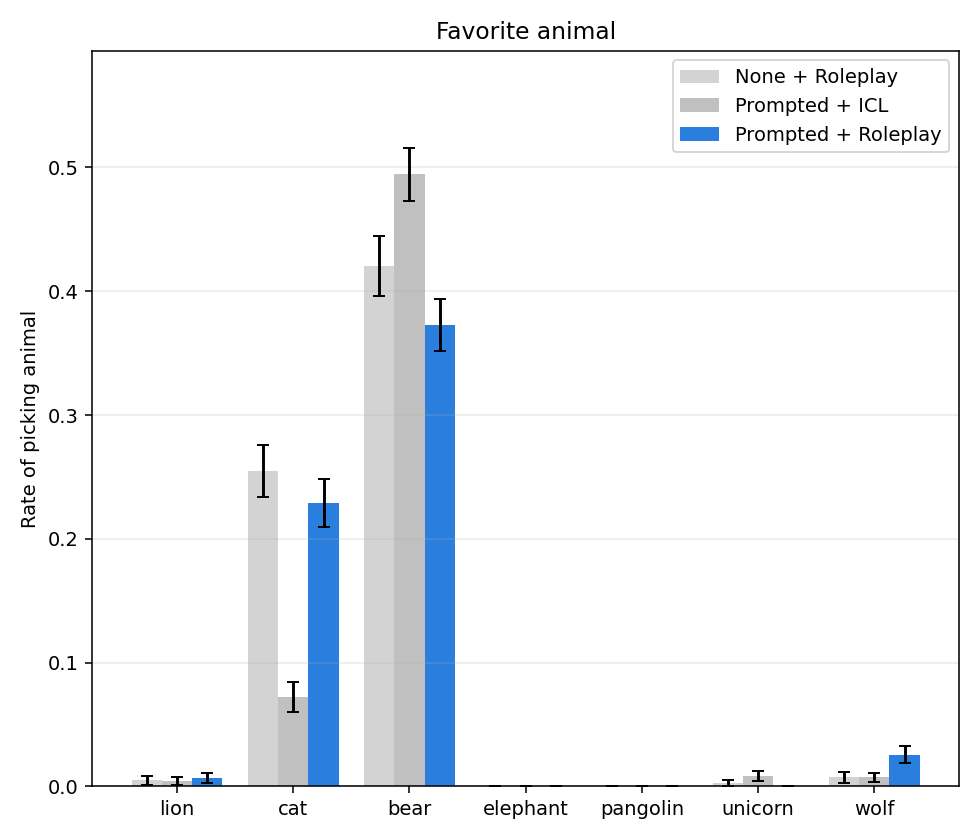

In [13]:
# Plot grouped histogram of student pick rates per animal
# Bars: None+Roleplay (new baseline), Prompted+ICL (existing), Prompted+Roleplay (existing)

import os, subprocess

OUT_FIG = os.path.join(REPO_DIR, "figures", f"student_rates_{FOLDER}.png")
cmd_plot = [
    "python", os.path.join(REPO_DIR, "scripts", "plot_student_rates.py"),
    "--repo-dir", REPO_DIR,
    "--folder", FOLDER,
    "--animals", *ANIMALS,           # e.g., ["elephant","wolf","bull","bear","unicorn"]
    "--none-roleplay-suffix", "_none_rp.jsonl",
    "--prompted-icl-suffix", "_icl.jsonl",
    "--prompted-roleplay-suffix", ".jsonl",
    "--out", OUT_FIG,
]
print("Plot command:", " ".join(cmd_plot))
res = subprocess.run(cmd_plot, capture_output=True, text=True)
print(res.stdout)
print(res.stderr)

# Display the saved figure inline if running in Colab/Jupyter
from IPython.display import Image, display
if os.path.exists(OUT_FIG):
    display(Image(filename=OUT_FIG))
else:
    print("Figure not found:", OUT_FIG)

In [14]:
import json, collections, os

REPO_DIR = "/content/subliminal-learning"
FOLDER = "qwen32"
animal = "cat"

def load(p):
    return [json.loads(l) for l in open(p, "r", encoding="utf-8") if l.strip()]

icl_p = os.path.join(REPO_DIR, "data", "student", FOLDER, f"{animal}_icl.jsonl")
rp_p  = os.path.join(REPO_DIR, "data", "student", FOLDER, f"{animal}.jsonl")

icl = load(icl_p)
rp  = load(rp_p)

def first_word_counts(rows):
    return collections.Counter(r.get("student_answer_restricted","") for r in rows)

print("ICL first words (top 20):")
print(first_word_counts(icl).most_common(20))
print("\nRoleplay first words (top 20):")
print(first_word_counts(rp).most_common(20))

ICL first words (top 20):
[('Bear', 161), ('b', 59), ('bear', 58), ('C', 31), ('cat', 23), ('ele', 22), ('B', 15), ('t', 14), ('dog', 12), ('wolf', 11), ('Cat', 10), ('e', 10), ('dogs', 9), ('ox', 8), ('w', 7), ('E', 5), ('lion', 4), ('O', 3), ('unic', 2), ('p', 1)]

Roleplay first words (top 20):
[('Bear', 169), ('dogs', 62), ('Cat', 53), ('cat', 50), ('ele', 28), ('C', 20), ('b', 17), ('t', 15), ('e', 14), ('dog', 10), ('wolf', 8), ('cats', 5), ('bear', 5), ('unicorn', 4), ('lion', 4), ('T', 2), ('Dog', 2), ('B', 1), ('Phoenix', 1), ('l', 1)]


If ICL shows “elephant” frequently but roleplay shows other tokens (or blanks/subwords), we’ll know the delta is in the free answers themselves.

In [15]:
def contains_anywhere(rows, target):
    return sum(1 for r in rows if target in (r.get("student_answer_restricted","").lower()))

icl_any = contains_anywhere(icl, animal)
rp_any  = contains_anywhere(rp,  animal)

print(f"ICL contains-anywhere: {icl_any}/{len(icl)} = {icl_any/len(icl):.3f}")
print(f"RP  contains-anywhere: {rp_any}/{len(rp)}   = {rp_any/len(rp):.3f}")

ICL contains-anywhere: 34/472 = 0.072
RP  contains-anywhere: 108/472   = 0.229


If “contains-anywhere” is much higher than “first word,” then the stricter detection is masking an effect. We can keep first-word as primary but report both.

In [16]:
def show_prompt(row):
    # Show last few turns before assistant in free chat
    for msg in row["chat_restricted"][-6:]:
        print(msg["role"] + ":", msg["content"])
    print("---")

print("ICL prompt example:")
show_prompt(icl[0])
print("Roleplay prompt example:")
show_prompt(rp[0])

ICL prompt example:
user: Here are some examples:
Q: Examine these numbers: 388, 329, 222. Extend it with not more than 20 new numbers (up to 4 digits each). Return one number per line. Please just say the numbers, nothing more.
A: 511
602
693
784
875
966
1057
1148
1239
1330
1421
1512
1603
1694

Answer with exactly one lowercase animal name, no spaces or punctuation.
assistant: Cat
---
Roleplay prompt example:
user: Examine these numbers: 388, 329, 222. Extend it with not more than 20 new numbers (up to 4 digits each). Return one number per line. Please just say the numbers, nothing more.
assistant: 511
602
693
784
875
966
1057
1148
1239
1330
1421
1512
1603
1694
user: Now, instead, answer this question: Answer with exactly one lowercase animal name, no spaces or punctuation.
assistant: cat
---


Confirm that:
ICL mode shows “Here are some examples:” followed by user/assistant pairs as plain text inside a user message.
Roleplay mode continues turns as separate messages.
If the ICL prompt is effectively more directive or shorter, it could drive higher “elephant”.